In [1]:
import pyrootutils
root = pyrootutils.setup_root(".", pythonpath=True, cwd=True)

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import pytorch_lightning as pl

from src.train import FaceAgeModule
from src.data.face_age_datamodule import FaceAgeDataModule

import warnings
warnings.filterwarnings("ignore")

In [3]:
age_norm_value = 80

In [4]:
model = FaceAgeModule.load_from_checkpoint("models/best-checkpoint.ckpt").eval()
dm = FaceAgeDataModule(normalize_age_by=age_norm_value, num_workers=8, batch_size=32)
dm.setup()

Loaded pretrained weights for efficientnet-b0


In [6]:
all_preds = []
all_targets = []

for x, y in tqdm(dm.test_dataloader()):

    preds = model.forward(x)
    preds = preds.detach()
    
    preds = preds.cpu().numpy() * age_norm_value
    targets = y.cpu().numpy() * age_norm_value
    
    preds = preds.clip(1, age_norm_value)
    
    all_preds.append(preds)
    all_targets.append(targets)

all_preds = np.concatenate(all_preds).astype(int)
all_targets = np.concatenate(all_targets).astype(int)

100%|██████████| 49/49 [01:05<00:00,  1.34s/it]


In [7]:
all_targets.shape, all_preds.shape
# print(all_preds.min(), all_preds.max())
# print(all_targets.min(), all_targets.max())

((1556, 1), (1556, 1))

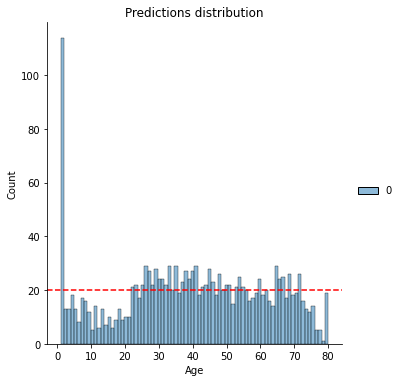

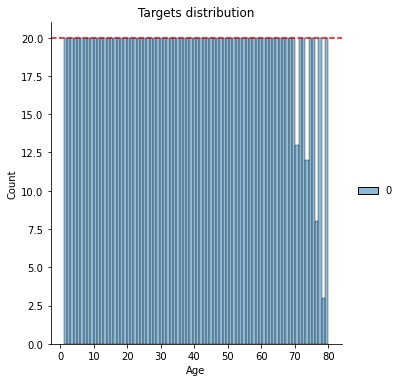

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.displot(all_preds,label="Predictions", bins=age_norm_value)
plt.xlabel("Age")
plt.title("Predictions distribution")
plt.axhline(y=20, color="r", ls="--")

plt.show()

sns.displot(all_targets, label="Targets", bins=age_norm_value)
plt.xlabel("Age")
plt.title("Targets distribution")
plt.axhline(y=20, color="r", ls="--")

plt.show()

In [9]:
# calculate MAE
from sklearn.metrics import mean_absolute_error

mean_absolute_error(all_targets, all_preds)

6.715938303341902

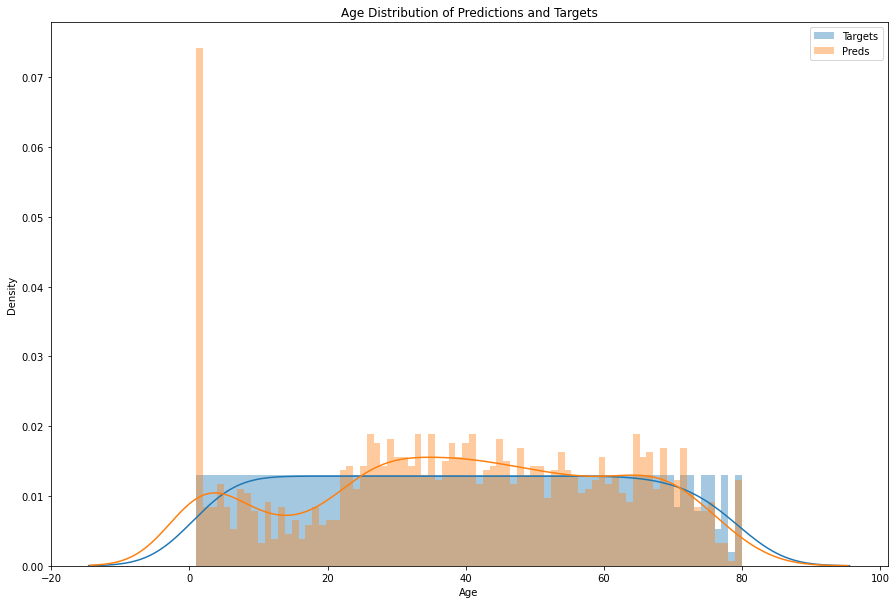

In [10]:
# set figure size
plt.figure(figsize=(15,10))

sns.distplot(all_targets, kde=True, bins=age_norm_value, label="Targets")
sns.distplot(all_preds, kde=True, bins=age_norm_value, label="Preds")

plt.title("Age Distribution of Predictions and Targets")
plt.xlabel("Age")

plt.legend()

In [11]:
# preds and targets are list of integers from range 1 to 80
# binarize them into `1-5``, `5-10`, `10-15`, ..., `75-80`

preds_binned = np.digitize(all_preds, np.arange(0, 85, 5))
targets_binned = np.digitize(all_targets, np.arange(0, 85, 5))

# calculate accuracy
acc = (preds_binned == targets_binned).mean()

print(acc)

0.2705655526992288


In [12]:
preds_binned = np.digitize(all_preds, np.arange(0, 85, 10))
targets_binned = np.digitize(all_targets, np.arange(0, 85, 10))

# calculate accuracy
acc = (preds_binned == targets_binned).mean()

print(acc)

0.4916452442159383


In [13]:
preds_binned = np.digitize(all_preds, np.arange(0, 85, 15))
targets_binned = np.digitize(all_targets, np.arange(0, 85, 15))

# calculate accuracy
acc = (preds_binned == targets_binned).mean()

print(acc)

0.6227506426735219


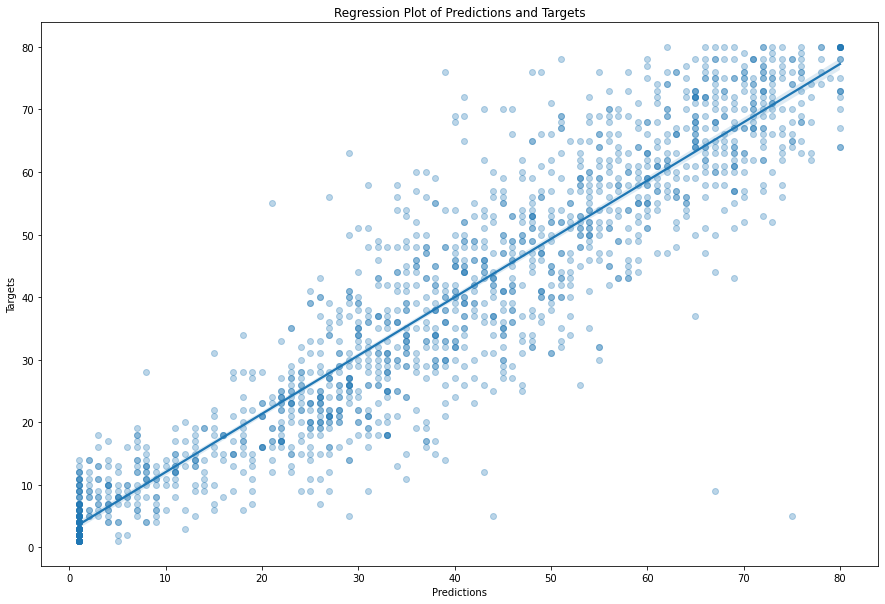

In [14]:
import seaborn as sns

plt.figure(figsize=(15,10))
sns.regplot(all_preds, all_targets, scatter_kws={"alpha": 0.3})
plt.xlabel("Predictions")
plt.ylabel("Targets")
plt.title("Regression Plot of Predictions and Targets")
plt.show()

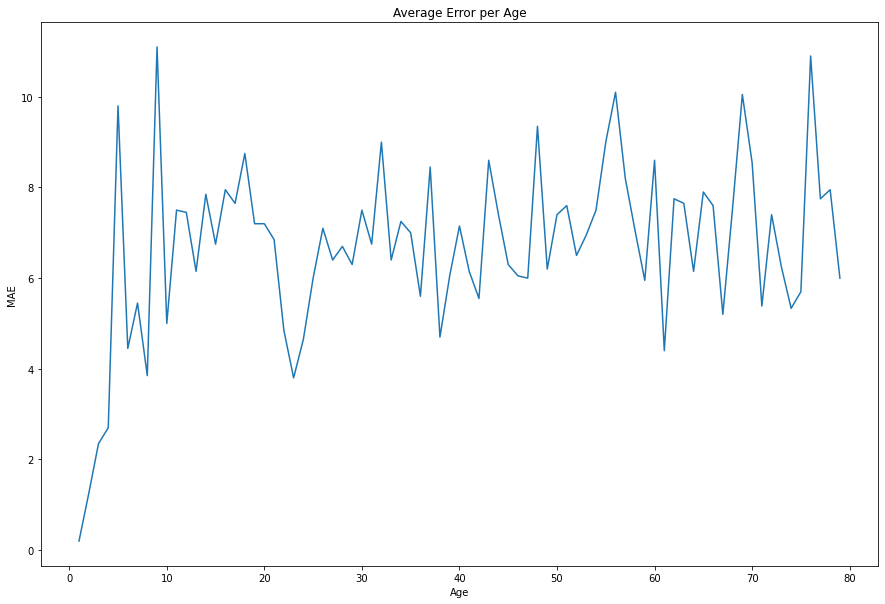

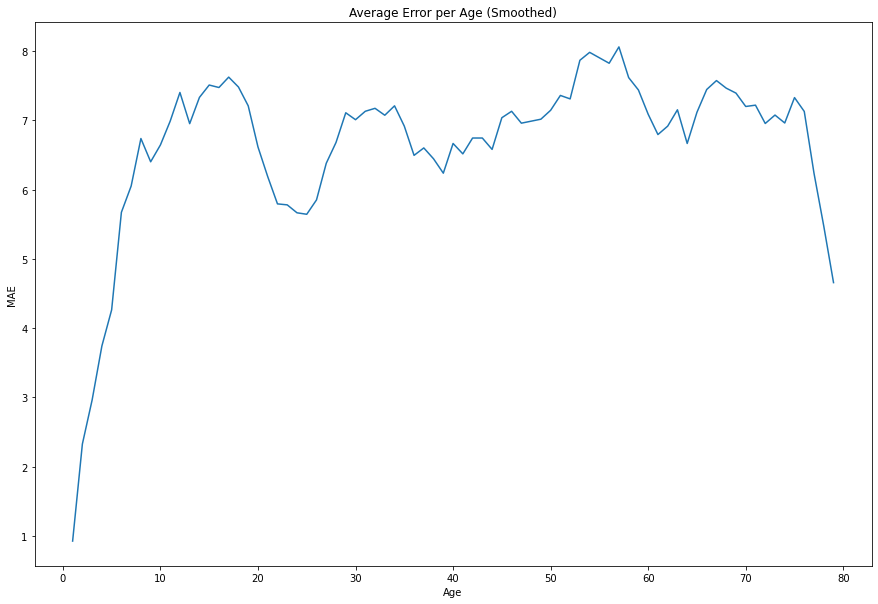

In [15]:
# compute average error per each age from 1 to 80

avg_error = []
for i in range(1, 80):
    avg_error.append(np.abs(all_preds[all_targets == i] - all_targets[all_targets == i]).mean())
    
plt.figure(figsize=(15,10))
plt.plot(range(1, 80), avg_error)
plt.xlabel("Age")
plt.ylabel("MAE")
plt.title("Average Error per Age")
plt.show()

# smooth over 7 bins
avg_error = np.convolve(avg_error, np.ones((7,))/7, mode='same')

plt.figure(figsize=(15,10))
plt.plot(range(1, 80), avg_error)
plt.xlabel("Age")
plt.ylabel("MAE")
plt.title("Average Error per Age (Smoothed)")
plt.show()

### Show 20 largest errors

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Target: [5], Pred: [75], Error: 70
Target: [9], Pred: [67], Error: 58
Target: [5], Pred: [44], Error: 39
Target: [76], Pred: [39], Error: 37
Target: [55], Pred: [21], Error: 34
Target: [63], Pred: [29], Error: 34
Target: [12], Pred: [43], Error: 31
Target: [72], Pred: [41], Error: 31
Target: [56], Pred: [27], Error: 29
Target: [69], Pred: [40], Error: 29
Target: [76], Pred: [48], Error: 28
Target: [37], Pred: [65], Error: 28
Target: [69], Pred: [41], Error: 28
Target: [68], Pred: [40], Error: 28
Target: [78], Pred: [51], Error: 27
Target: [26], Pred: [53], Error: 27
Target: [70], Pred: [43], Error: 27
Target: [76], Pred: [49], Error: 27
Target: [58], Pred: [31], Error: 27
Target: [43], Pred: [69], Error: 26


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


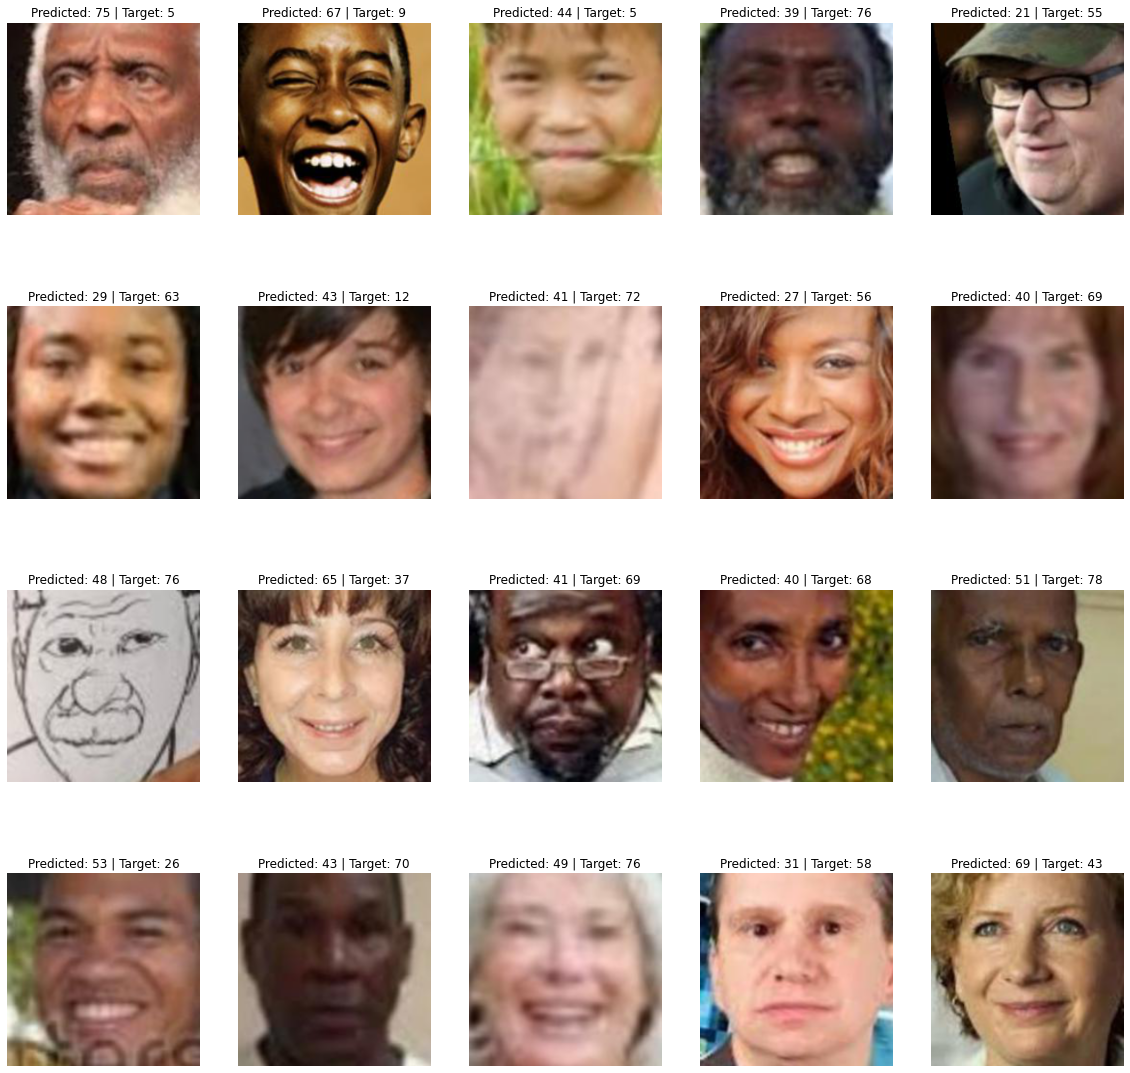

In [16]:
errors = np.abs((all_preds - all_targets))
errors = [int(x) for x in errors]

# find 20 biggest errors
biggest_errors = np.argsort(errors)[::-1][:20]

for i in biggest_errors:
    print(f"Target: {all_targets[i]}, Pred: {all_preds[i]}, Error: {errors[i]}")

plt.figure(figsize=(20,20))

for i, idx in enumerate(biggest_errors):
    plt.subplot(4, 5, i+1)
    
    img = dm.data_test[idx][0]
    
    # reshape for imshow
    img = np.transpose(img, (1, 2, 0))

    # fix normalization
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])

    plt.imshow(img)
    plt.title(f"Predicted: {all_preds[idx].squeeze()} | Target: {all_targets[idx].squeeze()}")
    plt.axis("off")
    
plt.show()